In [35]:
import pandas as pd
import requests
import numpy as np

import koreanize_matplotlib
import matplotlib.pyplot as plt

BASE_URL = "https://kosis.kr/openapi/Param/statisticsParameterData.do"

params = {
    "method":"getList",
    "apiKey":"ZWRiNzEyMzEwNGI5OWQ3NzcxNGM1MDNiOGJkOTQ0Y2M=",
    "itmId":"T2+",
    "objL1":"3404+3408+3436+3531+3642+", # 3704+
    "objL2":"S0+",
    "objL3":"",
    "objL4":"",
    "objL5":"",
    "objL6":"",
    "objL7":"",
    "objL8":"",
    "format":"json",
    "jsonVD":"Y",
    "prdSe":"H",
    "newEstPrdCnt":"7",
    "orgId":"101",
    "tblId":"DT_1ES3A02S"
}

response = requests.get(BASE_URL, params=params)
df_raw = pd.DataFrame(response.json())

In [15]:
keep_cols = ["PRD_DE", "C1", "C1_NM", "DT"]
missing = [c for c in keep_cols if c not in df_raw.columns]
if missing:
    raise ValueError(f"employment_raw에 필요한 컬럼이 없습니다: {missing}")

emp = df_raw[keep_cols].copy()
emp.columns = ["기간", "행정코드", "지역명", "값"]

emp["행정코드"] = emp["행정코드"].astype(str)
emp["값"] = pd.to_numeric(emp["값"], errors="coerce")

pivot_df = (
    emp
    .pivot_table(
        index=["행정코드", "지역명"],
        columns="기간",
        values="값",
        aggfunc="mean"
    )
    .reset_index()
)

pivot_df



기간,행정코드,지역명,202201,202202,202301,202302,202401,202402,202501
0,3404,아산시,196.2,204.5,208.4,211.9,221.5,225.2,231.7
1,3408,당진시,101.6,103.6,106.2,108.7,108.8,110.2,113.2
2,3436,홍성군,58.9,61.7,61.3,59.3,61.6,62.5,63.4
3,3531,완주군,52.4,55.4,58.9,60.6,60.7,60.7,61.4
4,3642,무안군,49.1,50.1,50.6,50.6,51.5,53.3,53.5
5,3704,안동시,85.4,86.8,88.1,89.2,88.7,85.7,86.9


# 인구 이동

In [ ]:
import pandas as pd

pd.set_option("display.max_rows", 10000)

include_regions = ["아산시", "무안군", "안동시", "완주군", "홍성군"]

def load_youth_pop_table(csv_path: str, ym: int, include_regions: list[str]) -> pd.DataFrame:
    
    df = pd.read_csv(csv_path, encoding="cp949")

    df["지역명"] = df["행정구역"].str.split("(").str[0].str.strip()
    df["행정코드"] = df["행정구역"].str.extract(r"\((\d+)\)").astype("Int64")

    # 시/군/구 단위만 추출 (결측 방지)
    sigungu = df.loc[
        df["행정코드"].notna()
        & (df["행정코드"] % 100_000_000 != 0)
        & (df["행정코드"] % 100_000 == 0)
    ].copy()

    # 연도/월에 맞는 컬럼명 구성
    year = ym // 100
    month = ym % 100
    
    prefix = f"{year}년{month:02d}월_계_"
    age_cols = [
        f"{prefix}20~24세",
        f"{prefix}25~29세",
        f"{prefix}15~19세",
    ]

    # 숫자 변환(안전)
    for c in age_cols:
        sigungu[c] = pd.to_numeric(
            sigungu[c].astype(str).str.replace(",", "", regex=False),
            errors="coerce"
        )

    sigungu["청년 총인구"] = sigungu[age_cols].sum(axis=1, skipna=True).astype("Int64")

    # 지역 필터링 개선: "… 아산시"처럼 끝단 정확 매칭
    suffixes = tuple(include_regions)
    local_sigungu = sigungu[sigungu["지역명"].str.endswith(suffixes)].copy()

    # 결과(지역명 키로 반환) - join 안전성 확보
    out = local_sigungu[["지역명", "청년 총인구"]].rename(columns={"청년 총인구": ym})

    return out


# =========================
# 여러 연월을 안전하게 결합 (지역명 기준 outer join)
# =========================
targets = [
    (202401, "../../data/202401_202401_연령별인구현황_월간.csv"),
    (202301, "../../data/202301_202301_연령별인구현황_월간.csv"),
    (202201, "../../data/202201_202201_연령별인구현황_월간.csv"),
]

all_result = None
for ym, path in targets:
    t = load_youth_pop_table(path, ym, include_regions)
    
    t.loc[t["지역명"].str.contains("전북특별자치도 완주군", na=False),"지역명"] = "전라북도 완주군"

    if all_result is None:
        all_result = t
    else:
        all_result = all_result.merge(t, on="지역명", how="outer")

# 보기 좋게 정렬 (최근월 컬럼 기준 내림차순 등 원하는 방식 가능)
all_result = all_result.sort_values("지역명").reset_index(drop=True)

display(all_result)


,지역명,202401,202301,202201
0,경상북도 안동시,21389,22047,22977
1,전라남도 무안군,13824,13800,13842
2,전라북도 완주군,13409,12819,12540
3,충청남도 당진시,22478,22633,22857
4,충청남도 아산시,56088,54974,53794
5,충청남도 홍성군,13266,13489,13831


In [ ]:
BASE_URL = "https://kosis.kr/openapi/Param/statisticsParameterData.do"

params = {
    "method":"getList",
    "apiKey":"ZWRiNzEyMzEwNGI5OWQ3NzcxNGM1MDNiOGJkOTQ0Y2M=",
    "itmId":"T21+",
    "objL1":"3404+3408+3436+3531+3642+", # 3704+
    "objL2":"",
    "objL3":"",
    "objL4":"",
    "objL5":"",
    "objL6":"",
    "objL7":"",
    "objL8":"",
    "format":"json",
    "jsonVD":"Y",
    "prdSe":"H",
    "newEstPrdCnt":"7",
    "orgId":"101",
    "tblId":"DT_1ES3A08S",
}

response = requests.get(BASE_URL, params=params)
df_raw = pd.DataFrame(response.json())

,C1_OBJ_NM,DT,C1,PRD_SE,UNIT_NM_ENG,ITM_ID,TBL_ID,ITM_NM,TBL_NM,PRD_DE,LST_CHN_DE,C1_NM_ENG,C1_NM,UNIT_NM,ITM_NM_ENG,ORG_ID,C1_OBJ_NM_ENG
0,행정구역별,38.6,3404,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202201,2022-08-05,Asan-si,아산시,천명,- Age group(15~29 Years old),101,By administrative divisions
1,행정구역별,38,3404,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202202,2023-02-03,Asan-si,아산시,천명,- Age group(15~29 Years old),101,By administrative divisions
2,행정구역별,36.2,3404,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202301,2023-07-31,Asan-si,아산시,천명,- Age group(15~29 Years old),101,By administrative divisions
3,행정구역별,36.6,3404,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202302,2024-01-18,Asan-si,아산시,천명,- Age group(15~29 Years old),101,By administrative divisions
4,행정구역별,37.4,3404,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202401,2024-08-02,Asan-si,아산시,천명,- Age group(15~29 Years old),101,By administrative divisions


In [29]:
keep_cols = ["PRD_DE", "C1", "C1_NM", "DT"]
missing = [c for c in keep_cols if c not in df_raw.columns]
if missing:
    raise ValueError(f"employment_raw에 필요한 컬럼이 없습니다: {missing}")

emp = df_raw[keep_cols].copy()
emp.columns = ["기간", "행정코드", "지역명", "값"]

emp["행정코드"] = emp["행정코드"].astype(str)
emp["값"] = pd.to_numeric(emp["값"], errors="coerce")

pivot_df = (
    emp
    .pivot_table(
        index=["행정코드", "지역명"],
        columns="기간",
        values="값",
        aggfunc="mean"  # 동일 키 중복 시 평균(보통 중복 없어야 정상)
    )
    .reset_index()
)

jan_cols = [c for c in pivot_df.columns if str(c).endswith("01")]

pivot_df = pivot_df[["행정코드", "지역명"] + jan_cols]


,지역명,202401,202301,202201
0,경상북도 안동시,21389,22047,22977
1,전라남도 무안군,13824,13800,13842
2,전라북도 완주군,13409,12819,12540
3,충청남도 당진시,22478,22633,22857
4,충청남도 아산시,56088,54974,53794
5,충청남도 홍성군,13266,13489,13831


기간,행정코드,지역명,202201,202301,202401,202501
0,3404,아산시,38.6,36.2,37.4,36.5
1,3408,당진시,11.4,11.1,11.1,10.6
2,3436,홍성군,9.0,8.9,9.3,9.5
3,3531,완주군,11.2,9.8,10.0,11.3
4,3642,무안군,13.1,12.3,11.9,12.0
5,3704,안동시,17.7,13.8,14.1,16.1


In [22]:
# 1) all_result에 "시군구" 컬럼 만들기 (마지막 단어)
all_tmp = all_result.copy()
all_tmp["시군구"] = all_tmp["지역명"].astype(str).str.split().str[-1]

# 2) pivot_df도 키 컬럼 통일
pv_tmp = pivot_df.copy()
pv_tmp["시군구"] = pv_tmp["지역명"].astype(str)

# 3) 공통 기간(컬럼)만 뽑기
period_cols = [202201, 202301, 202401]

pv_tmp = pv_tmp.rename(
    columns=lambda c: int(c) if str(c).isdigit() else c
)

# # 4) pivot_df 숫자만 *1000
pv_tmp[period_cols] = pv_tmp[period_cols].mul(1000)


display(all_tmp)
display(pv_tmp)

# # 5) 시군구 키로 merge 후 차이 계산 (all - pivot*1000)
merged = all_tmp[["시군구"] + period_cols].merge(
    pv_tmp[["시군구"] + period_cols],
    on="시군구",
    how="inner",
    suffixes=("_all", "_pv")
)

diff = merged[["시군구"]].copy()
for c in period_cols:
    diff[c] = merged[f"{c}_all"] - merged[f"{c}_pv"]

diff


,지역명,202401,202301,202201,시군구
0,경상북도 안동시,21389,22047,22977,안동시
1,전라남도 무안군,13824,13800,13842,무안군
2,전라북도 완주군,13409,12819,12540,완주군
3,충청남도 당진시,22478,22633,22857,당진시
4,충청남도 아산시,56088,54974,53794,아산시
5,충청남도 홍성군,13266,13489,13831,홍성군


기간,행정코드,지역명,202201,202301,202401,202501,시군구
0,3404,아산시,38600.0,36200.0,37400.0,36.5,아산시
1,3408,당진시,11400.0,11100.0,11100.0,10.6,당진시
2,3436,홍성군,9000.0,8900.0,9300.0,9.5,홍성군
3,3531,완주군,11200.0,9800.0,10000.0,11.3,완주군
4,3642,무안군,13100.0,12300.0,11900.0,12.0,무안군
5,3704,안동시,17700.0,13800.0,14100.0,16.1,안동시


,시군구,202201,202301,202401
0,안동시,5277.0,8247.0,7289.0
1,무안군,742.0,1500.0,1924.0
2,완주군,1340.0,3019.0,3409.0
3,당진시,11457.0,11533.0,11378.0
4,아산시,15194.0,18774.0,18688.0
5,홍성군,4831.0,4589.0,3966.0


In [30]:
import pandas as pd
import numpy as np
import requests

BASE_URL = "https://kosis.kr/openapi/Param/statisticsParameterData.do"

def load_inactive_youth_from_kosis(
    objL1_codes: list[str],
    tblId: str = "DT_1ES3A08S",
    itmId: str = "T21+",
    orgId: str = "101",
    apiKey: str = "ZWRiNzEyMzEwNGI5OWQ3NzcxNGM1MDNiOGJkOTQ0Y2M=",
    prdSe: str = "H",
    last_cnt: int = 7,
) -> pd.DataFrame:
    params = {
        "method": "getList",
        "apiKey": apiKey,
        "orgId": orgId,
        "tblId": tblId,
        "itmId": itmId,
        "objL1": "+".join(objL1_codes) + "+",
        "format": "json",
        "jsonVD": "Y",
        "prdSe": prdSe,            # H=반기
        "newEstPrdCnt": str(last_cnt),
    }

    r = requests.get(BASE_URL, params=params)
    r.raise_for_status()
    raw = pd.DataFrame(r.json())

    keep = ["PRD_DE", "C1", "C1_NM", "DT"]
    missing = [c for c in keep if c not in raw.columns]
    if missing:
        raise ValueError(f"KOSIS 응답에 필요한 컬럼이 없습니다: {missing}")

    emp = raw[keep].copy()
    emp.columns = ["기간", "행정코드", "지역명", "값"]

    emp["행정코드"] = emp["행정코드"].astype(str)
    emp["값"] = pd.to_numeric(emp["값"], errors="coerce")

    pivot = (
        emp.pivot_table(
            index=["행정코드", "지역명"],
            columns="기간",
            values="값",
            aggfunc="mean"
        )
        .reset_index()
    )

    # 반기자료에서 "01" = 상반기(H1)로 사용되는 경우가 많음 → 상반기만 사용
    h1_cols = [c for c in pivot.columns if str(c).isdigit() and str(c).endswith("01")]
    pivot = pivot[["행정코드", "지역명"] + h1_cols].copy()

    # 기간 컬럼을 int로 변환 (202201 형태)
    pivot = pivot.rename(columns=lambda c: int(c) if str(c).isdigit() else c)

    return pivot


# =========================
# 1) 비경제활동인구(천명) 불러오기
# =========================
objL1_codes = ["3404", "3408", "3436", "3531", "3642", "3704"]  # 아산, 당진, 홍성, 완주, 무안, 안동
pivot_df = load_inactive_youth_from_kosis(objL1_codes)

# =========================
# 2) all_result(청년 총인구)와 merge 키 맞추기 (시군구)
#    - 현재 범위(6개 지역)는 안전하지만, 전국 확장 시 '중구' 같은 충돌 위험 있음
# =========================
period_cols = [202201, 202301, 202401]  # 계산에 쓸 기간만 명시적으로 지정

all_tmp = all_result.copy()
all_tmp["시군구"] = all_tmp["지역명"].astype(str).str.split().str[-1]

pv_tmp = pivot_df.copy()
pv_tmp["시군구"] = pv_tmp["지역명"].astype(str)

# 필요한 기간 컬럼만 남기기 (없는 경우 에러)
need_all = ["시군구"] + period_cols
need_pv = ["시군구"] + period_cols
miss_all = [c for c in need_all if c not in all_tmp.columns]
miss_pv = [c for c in need_pv if c not in pv_tmp.columns]
if miss_all:
    raise ValueError(f"all_result에 필요한 컬럼이 없습니다: {miss_all}")
if miss_pv:
    raise ValueError(f"pivot_df에 필요한 컬럼이 없습니다: {miss_pv}")

# =========================
# 3) 단위 변환: 비경제활동인구는 '천명' → '명'
# =========================
pv_tmp[period_cols] = pv_tmp[period_cols].mul(1000)

# =========================
# 4) merge 후 경제활동인구(= 총 - 비경활) 계산
# =========================
merged = (
    all_tmp[["시군구"] + period_cols]
    .merge(
        pv_tmp[["시군구"] + period_cols],
        on="시군구",
        how="inner",
        suffixes=("_총", "_비경활")
    )
)

diff = merged[["시군구"]].copy()
for c in period_cols:
    diff[c] = merged[f"{c}_총"] - merged[f"{c}_비경활"]

# 결과: 청년 경제활동인구(추정)
display(diff)


,시군구,202201,202301,202401
0,안동시,5277.0,8247.0,7289.0
1,무안군,742.0,1500.0,1924.0
2,완주군,1340.0,3019.0,3409.0
3,당진시,11457.0,11533.0,11378.0
4,아산시,15194.0,18774.0,18688.0
5,홍성군,4831.0,4589.0,3966.0


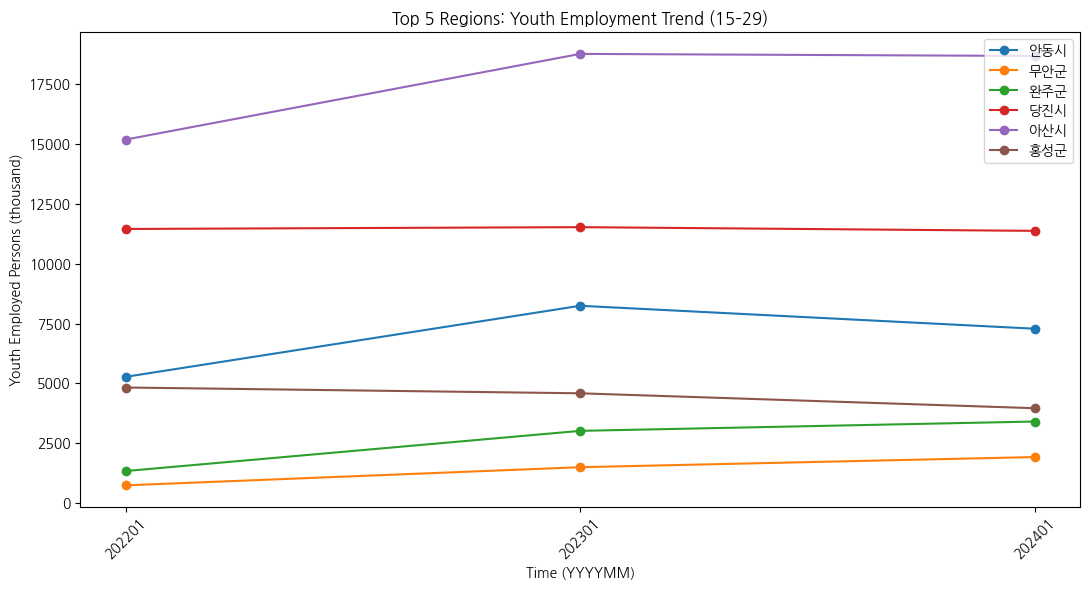

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 기간 컬럼 자동 추출 (숫자형 YYYYMM)
pivot_df = pivot_df.loc[~(pivot_df['지역명'] == '아산시')].copy()

time_cols = sorted([c for c in diff.columns if str(c).isdigit()])

plt.figure(figsize=(11, 6))

for _, row in diff.iterrows():
    y = row[time_cols].astype(float).values
    plt.plot(time_cols, y, marker="o", label=row["시군구"])

plt.xlabel("Time (YYYYMM)")
plt.ylabel("Youth Employed Persons (thousand)")
plt.title("Top 5 Regions: Youth Employment Trend (15–29)")
plt.xticks(time_cols, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

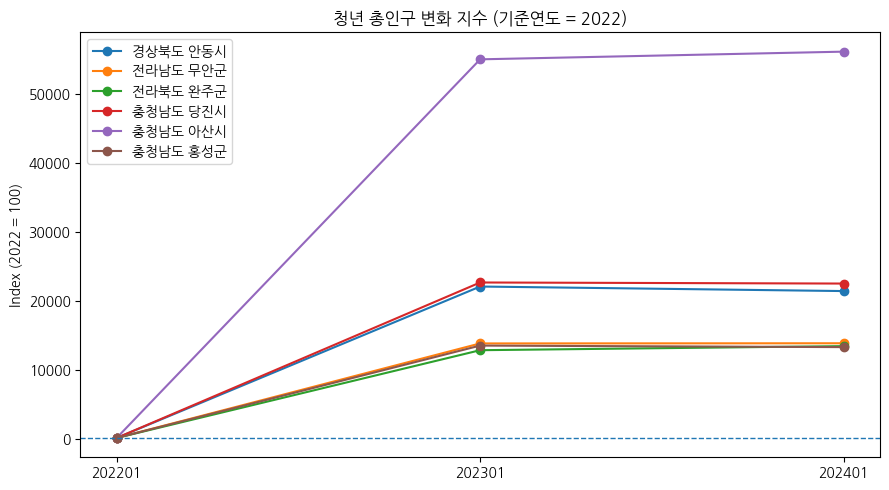

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# ===== 준비 =====
df = all_result.copy()

year_cols = [202201, 202301, 202401]
base_year = 202201

# ===== Index 계산 =====
index_df = df[["지역명"] + year_cols].copy()

for y in year_cols:
    index_df[y] = (index_df[y] / index_df[base_year]) * 100

# ===== 시각화 =====
plt.figure(figsize=(9, 5))

for _, row in index_df.iterrows():
    plt.plot(
        year_cols,
        row[year_cols].values,
        marker="o",
        label=row["지역명"]
    )

plt.axhline(100, linestyle="--", linewidth=1)
plt.xticks(year_cols)
plt.ylabel("Index (2022 = 100)")
plt.title("청년 총인구 변화 지수 (기준연도 = 2022)")
plt.legend()
plt.tight_layout()
plt.show()


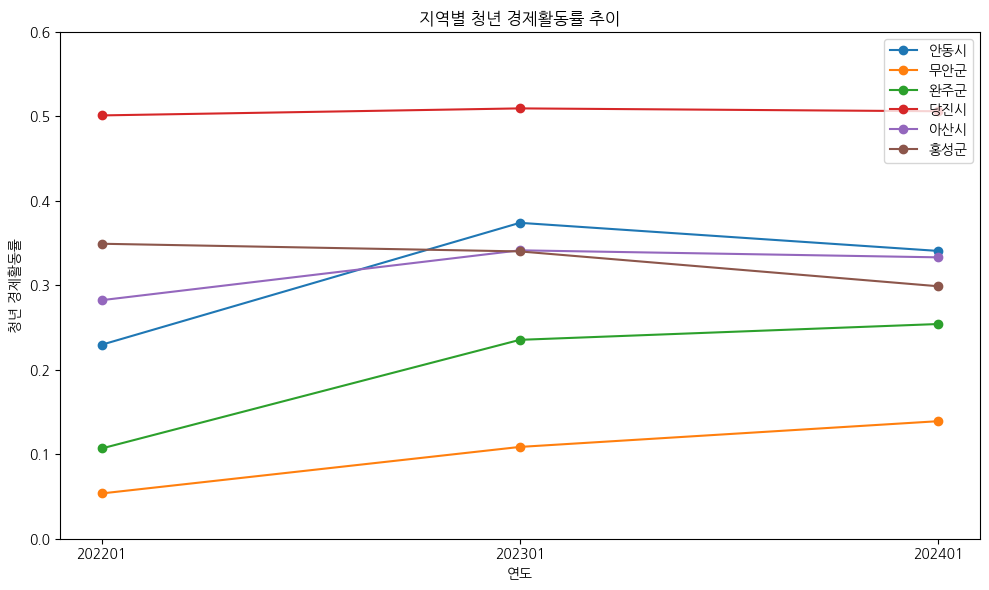

In [33]:
import matplotlib.pyplot as plt

# =========================
# 2) 청년 경제활동률 선 그래프
# =========================

plt.figure(figsize=(10, 6))

x = period_cols

for _, row in rate_df.iterrows():
    y = row[period_cols].astype(float).values
    plt.plot(x, y, marker="o", label=row["지역"])

plt.ylim(0, 0.6)
plt.xticks(period_cols)
plt.xlabel("연도")
plt.ylabel("청년 경제활동률")
plt.title("지역별 청년 경제활동률 추이")

plt.legend()
plt.tight_layout()
plt.show()
